# Blogs & Explain

## [Pytorch手撕经典网络之LeNet5](https://zhuanlan.zhihu.com/p/29716516)
+ 知乎专栏
+ 手动实现了数据的加载与可视化的内容, 比较的原生态
+ 手动指定每一层的形式

## [PyTorch——LeNet实现（附完整代码）](https://blog.csdn.net/beilizhang/article/details/114483822)

+ CSDN, 不是很行的网站
+ 基于torchvision获取数据
+ 使用Sequential构建网络

## [动手学深度学习-5.5 LeNet](https://tangshusen.me/Dive-into-DL-PyTorch/#/chapter05_CNN/5.5_lenet)

+ 一个online书籍教程的一部分, 体验极佳
+ 配合书籍, 使用了`d2lzh_pytorch`这个特化包

## [LeNet-5 Implementation on MNIST in PyTorch](https://medium.com/@deepeshdeepakdd2/lenet-5-implementation-on-mnist-in-pytorch-c6f2ee306e37)
+ 还包括很多数据可视化等通用性的额外功能代码, 值得初学上手细品

## [我用 PyTorch 复现了 LeNet-5 神经网络（自定义数据集篇）！](https://cloud.tencent.com/developer/article/1931716)
+ 主要是自己搞了一套数据集去用LeNet训练



# Paper

+ 典中典1998! [Lecun : Gradient-based learning applied to document recognition](https://www.doi.org/10.1109/5.726791)

# MineCode

## 0. import packages

In [109]:
import sys
import time
import shutil

import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn

from torch.utils.tensorboard import SummaryWriter

import progressbar

import matplotlib.pyplot as plt

## 1. 数据加载

In [160]:
mnist_train = torchvision.datasets.FashionMNIST(root='./FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='./FashionMNIST', train=False, download=True, transform=transforms.ToTensor())



if sys.platform.startswith('win'):
    num_workers = 0
else:
    num_workers = 4

batch_size = 256

    
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
# test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=len(mnist_test), num_workers=num_workers)

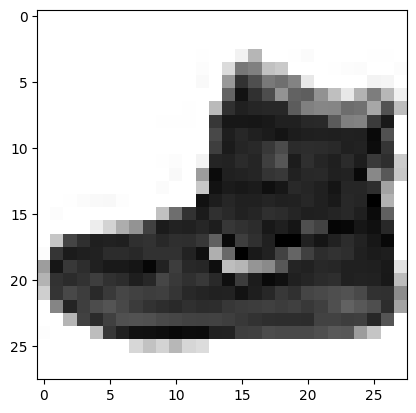

In [40]:
plt.imshow(mnist_train.data[0,:,:], cmap='binary')

## 2. 构建模型

In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5), # in_channels, out_channels, kernel_size
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2), # kernel_size, stride
            nn.Conv2d(6, 16, 5),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16*4*4, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

## 3. performance 

In [106]:
def perf(Y_pred, Y_true):
    global TP, TN, FP, FN
    assert len(Y_pred.shape) == 2 and len(Y_true.shape) == 1
    assert Y_pred.shape[0] == Y_true.shape[0]

    nclass = Y_pred.shape[1]
    Y_pred_idx = Y_pred.argmax(dim=1)
    
    accuracy = (Y_pred_idx == Y_true).sum() / Y_true.shape[0]
    metrics_multiclass = []
    for ic in range(nclass):
        if isinstance(Y_pred, np.ndarray):
            TP = np.argwhere(np.where(Y_pred_idx == ic, 1, 0) + np.where(Y_true == ic, 1, 0) == 2).size()
            TN = np.argwhere(np.where(Y_pred_idx != ic, 1, 0) + np.where(Y_true != ic, 1, 0) == 2).size()
            FP = np.argwhere(np.where(Y_pred_idx == ic, 1, 0) + np.where(Y_true != ic, 1, 0) == 2).size()
            FN = np.argwhere(np.where(Y_pred_idx != ic, 1, 0) + np.where(Y_true == ic, 1, 0) == 2).size()
        elif isinstance(Y_pred, torch.Tensor):
            TP = torch.argwhere(torch.where(Y_pred_idx == ic, 1, 0) + torch.where(Y_true == ic, 1, 0) == 2).numel()
            TN = torch.argwhere(torch.where(Y_pred_idx != ic, 1, 0) + torch.where(Y_true != ic, 1, 0) == 2).numel()
            FP = torch.argwhere(torch.where(Y_pred_idx == ic, 1, 0) + torch.where(Y_true != ic, 1, 0) == 2).numel()
            FN = torch.argwhere(torch.where(Y_pred_idx != ic, 1, 0) + torch.where(Y_true == ic, 1, 0) == 2).numel()
        precision = TP / (TP + FP) # correctly predicted positive in all predicted positive
        recall = TP / (TP + FN)  # correctly predicted positive in all actual positive
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        F1 = 2 * precision + recall / (precision + recall)
        metrics_multiclass.append({
            'TP' : TP,
            'TN' : TN,
            'FP' : FP,
            'FN' : FN,
            'precision' : precision,
            'recall' : recall,
            'accuracy' : accuracy
        })
    return accuracy, metrics_multiclass

## 4. 训练

In [146]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [181]:
net = LeNet().to(device)

shutil.rmtree('runs')

writer = SummaryWriter(comment='LeNet',filename_suffix="_LeNet")

writer.add_graph(net, mnist_train[0][0].to(device))

train_losses_by_epoch = []
train_acc_by_epoch = []
train_losses_by_batch = []


In [182]:
def train(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs):
    global y_hat, y
#     net = net.to(device)
    print("training on ", device)
    loss = torch.nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.time()
        train_losses_by_batch = []
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            
            l = loss(y_hat, y)
            
            train_losses_by_batch.append(l.item())
            
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            n += y.shape[0]
            batch_count += 1
        
        train_losses_by_epoch.append(np.array(train_losses_by_batch).mean())
        
        x_test, y_test = next(iter(test_iter))
        y_hat_test = net(x_test.to(device))
        acc = (y_hat_test.argmax(dim=1) == y_test.to(device)).sum() / y_test.numel()
        train_acc_by_epoch.append(acc)
        
        writer.add_scalar('Loss/train', train_losses_by_epoch[-1], epoch)
        writer.add_scalar('Acc/train', train_acc_by_epoch[-1], epoch)
        if epoch % 5 == 0:
            print("epoch {}/{}, loss in train is {:.3f}, @{}".format(epoch, num_epochs, l.item(), time.strftime("%H:%M:%S")))
        

In [183]:
lr, num_epochs = 0.001, 100
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
train(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on  cuda
epoch 0/100, loss in train is 1.175, @17:09:28
epoch 5/100, loss in train is 0.504, @17:10:08
epoch 10/100, loss in train is 0.328, @17:10:47
epoch 15/100, loss in train is 0.281, @17:11:27
epoch 20/100, loss in train is 0.418, @17:12:07
epoch 25/100, loss in train is 0.386, @17:12:46
epoch 30/100, loss in train is 0.310, @17:13:26
epoch 35/100, loss in train is 0.345, @17:14:07
epoch 40/100, loss in train is 0.157, @17:14:48
epoch 45/100, loss in train is 0.308, @17:15:28
epoch 50/100, loss in train is 0.310, @17:16:09
epoch 55/100, loss in train is 0.347, @17:16:50
epoch 60/100, loss in train is 0.282, @17:17:31
epoch 65/100, loss in train is 0.347, @17:18:12
epoch 70/100, loss in train is 0.367, @17:18:51
epoch 75/100, loss in train is 0.311, @17:19:32
epoch 80/100, loss in train is 0.225, @17:20:12
epoch 85/100, loss in train is 0.216, @17:20:53
epoch 90/100, loss in train is 0.151, @17:21:33
epoch 95/100, loss in train is 0.165, @17:22:14


In [184]:
writer.close()

# Bugs & Issues

## 1. Dataset -> DataLoader的channel问题, 为啥自动加了dim?

+ 其实没有, 其实是Dataset的`__getitem__`里实现的方法, 他就给加了channel dim! DataLoader是无辜的!

## 2. DataLoader怎么单batch然后取值?

+ 1个batch么就`batch_size = len(dataset)`
+ 取值么就`next(iter(dataloader))`

## 3. 可视化怎么搞?

+ 全面拥抱tensorboard! loss的和graph的, 好使!
+ 过程中可视化通过add_scalar实现

## 4. performance怎么衡量?

+ 除了CrossEntropy loss, 还统计了acc作为by_epoch关注量, 同时, train完统计multi-class的precision, recall, accuracy, f1-score

# Extend

## CNN怎么去做regression任务呢?

+ 发现能搜到paper, ok, 看paper去!